In [1]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from triplet_utils import *
from utils import *
from torch.utils.data import random_split
from triplet_utils import train_and_evaluate_triplet

# 2. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 3. Create the dataset and dataloader
folder_path = '../../data/BiteCount/salient_poses/'   # Adjust this path
dataset = TripletDataset(folder_path, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

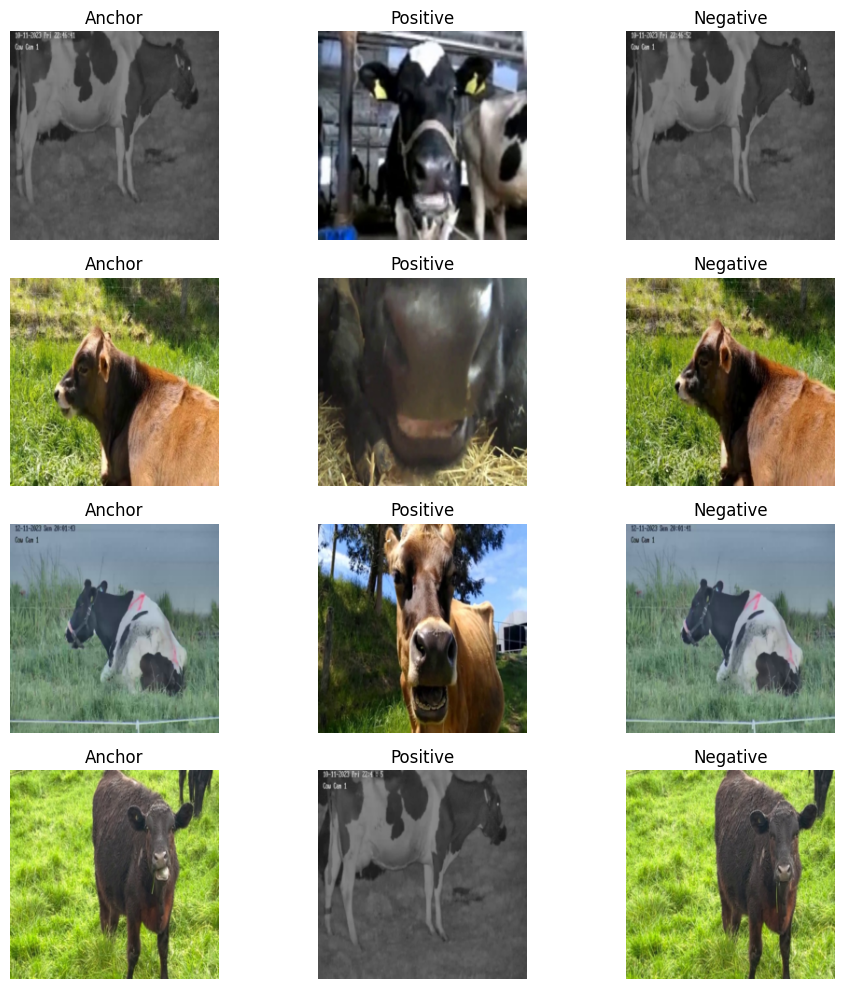

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Function to show a batch of triplets
def show_triplet_images(dataloader, num_triplets=4):
    # Get a batch of data
    anchor_batch, positive_batch, negative_batch, _ = next(iter(dataloader))
    
    # Set up matplotlib subplots
    fig, axes = plt.subplots(num_triplets, 3, figsize=(10, 10))

    # Convert tensors to numpy arrays for visualization
    def convert_tensor_to_img(tensor):
        # Convert to numpy, [C, H, W] -> [H, W, C]
        image = tensor.numpy().transpose((1, 2, 0))  # Permute to [H, W, C]
        image = np.clip(image, 0, 1)  # Clip any out-of-bound values (if necessary)
        return image
    
    # Show num_triplets triplet images (anchor, positive, negative)
    for i in range(num_triplets):
        # No need to permute in the caller; it is done inside convert_tensor_to_img
        anchor_img = convert_tensor_to_img(anchor_batch[i])
        positive_img = convert_tensor_to_img(positive_batch[i])
        negative_img = convert_tensor_to_img(negative_batch[i])

        # Display anchor, positive, negative in a row
        axes[i, 0].imshow(anchor_img)
        axes[i, 0].set_title('Anchor')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(positive_img)
        axes[i, 1].set_title('Positive')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(negative_img)
        axes[i, 2].set_title('Negative')
        axes[i, 2].axis('off')

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()

# Example usage
show_triplet_images(dataloader, num_triplets=4)


In [3]:
def custom_collate(batch):
    # Unpack the batch
    anchors, positives, negatives, labels = zip(*batch)

    # Stack tensors to create batches
    anchors = torch.stack(anchors)
    positives = torch.stack(positives)
    negatives = torch.stack(negatives)

    # Convert labels to a tensor
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    return anchors, positives, negatives, labels


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

# TripletModel definition
class TripletModel(nn.Module):
    def __init__(self):
        super(TripletModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2048)  # Adjust output size for embedding

    def forward(self, x):
        # Get the embedding directly from the base model
        return self.base_model(x)  # Call the model with input x

class TripletClassifier(nn.Module):
    def __init__(self, triplet_head, output_size=1):
        super(TripletClassifier, self).__init__()
        self.triplet_head = triplet_head
        self.classifier = nn.Linear(self.triplet_head.base_model.fc.out_features, output_size)  # Binary classification (logits)

    def forward(self, x):
        embedding = self.triplet_head(x)  # Output of base model
        class_output = self.classifier(embedding)  # Output for classification
        return embedding, class_output
# Load data
data_dir = '../../data/BiteCount/salient_poses/'

# Define transformations for training set and validation set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to square input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to square input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = TripletDataset(data_dir, transform=train_transforms)
dataset_size = len(train_dataset)
class_names = train_dataset.classes

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameters
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 50
patience = 5
alpha = 0.7

# Placeholder to store metrics across folds
val_accuracies = []
val_f1_scores = []
precisions = []
recalls = []
roc_aucs = []

# Perform 5-Fold Cross Validation
fold_idx = 1

np.random.seed(42)

for train_idx, val_idx in kf.split(np.arange(dataset_size)):
    print(f"Fold {fold_idx}")

    # Subset the data for training and validation
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    # Create DataLoader for train and validation
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    # Initialize TripletModel
    triplet_model = TripletModel()
    # triplet_model.load_state_dict(torch.load('./triplet_model.pth'))
    model = TripletClassifier(triplet_model)
    model = model.to(device)

    # Define loss functions and optimizer
    criterion_classification = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits for binary classification
    criterion_triplet = nn.TripletMarginLoss(margin=1)  # Triplet margin loss
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

    # Training loop with early stopping
    best_val_accuracy = float('inf')
    best_val_f1 = 0

    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            # Unpack the batch correctly
            anchor, positive, negative, labels = batch
            
            # Move the tensors to the appropriate device
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            labels = labels.to(device)  # Ensure labels are tensors

            # Forward pass
            anchor_embedding, anchor_output = model(anchor)
            positive_embedding, positive_output = model(positive)
            negative_embedding, negative_output = model(negative)

            # Calculate losses
            classification_loss = criterion_classification(anchor_output, labels)
            triplet_loss = criterion_triplet(anchor_embedding, positive_embedding, negative_embedding)

            # Combine losses
            loss = alpha * classification_loss + (1-alpha) * triplet_loss
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                anchor, positive, negative, labels = batch
                
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)
                labels = labels.to(device)

                anchor_embedding, anchor_output = model(anchor)
                positive_embedding, positive_output = model(positive)
                negative_embedding, negative_output = model(negative)

                # Compute validation loss
                classification_loss = criterion_classification(anchor_output, labels)
                triplet_loss = criterion_triplet(anchor_embedding, positive_embedding, negative_embedding)
                val_loss += (classification_loss + triplet_loss).item()

                val_preds.append(torch.sigmoid(anchor_output).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)

        # Calculate metrics
        val_acc = accuracy_score(val_labels, (val_preds > 0.5).astype(int))
        val_f1 = f1_score(val_labels, (val_preds > 0.5).astype(int))
        precision = precision_score(val_labels, (val_preds > 0.5).astype(int))
        recall = recall_score(val_labels, (val_preds > 0.5).astype(int))
        roc_auc = roc_auc_score(val_labels, val_preds)

        # Print validation metrics
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, ROC AUC: {roc_auc:.4f}")

        # Early stopping logic
        if val_acc > best_val_accuracy or val_f1 > best_val_f1:
            best_val_loss = avg_val_loss
            best_val_accuracy = val_acc
            best_val_f1 = val_f1
            best_precision = precision
            best_recall = recall
            best_roc_auc = roc_auc
            patience_counter = 0
            # Save model state
            torch.save(model.state_dict(), f'modified_tripet_margin_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Store fold metrics
    val_accuracies.append(best_val_accuracy)
    val_f1_scores.append(best_val_f1)
    precisions.append(best_precision)
    recalls.append(best_recall)
    roc_aucs.append(best_roc_auc)

    fold_idx += 1

    

# Print out the results after cross-validation
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(val_f1_scores):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f}")

Fold 1


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 2.3776
Validation Loss: 6.0034, Accuracy: 0.4250, F1 Score: 0.5965, Precision: 0.4250, Recall: 1.0000, ROC AUC: 0.3715
Epoch [2/50], Loss: 1.6688
Validation Loss: 4.5157, Accuracy: 0.4125, F1 Score: 0.5688, Precision: 0.4133, Recall: 0.9118, ROC AUC: 0.3715
Epoch [3/50], Loss: 1.3787
Validation Loss: 4.0640, Accuracy: 0.5125, F1 Score: 0.3810, Precision: 0.4138, Recall: 0.3529, ROC AUC: 0.5486
Epoch [4/50], Loss: 1.3077
Validation Loss: 3.9560, Accuracy: 0.4375, F1 Score: 0.5946, Precision: 0.4286, Recall: 0.9706, ROC AUC: 0.4815
Epoch [5/50], Loss: 1.1406
Validation Loss: 2.9663, Accuracy: 0.6125, F1 Score: 0.2791, Precision: 0.6667, Recall: 0.1765, ROC AUC: 0.6560
Epoch [6/50], Loss: 1.0941
Validation Loss: 3.2358, Accuracy: 0.4125, F1 Score: 0.5841, Precision: 0.4177, Recall: 0.9706, ROC AUC: 0.5914
Epoch [7/50], Loss: 1.0043
Validation Loss: 3.0073, Accuracy: 0.5500, F1 Score: 0.5714, Precision: 0.4800, Recall: 0.7059, ROC AUC: 0.6292
Epoch [8/50], Loss: 0.9798


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 2.3899
Validation Loss: 5.4938, Accuracy: 0.4625, F1 Score: 0.5657, Precision: 0.4667, Recall: 0.7179, ROC AUC: 0.4165
Epoch [2/50], Loss: 1.6366
Validation Loss: 4.5754, Accuracy: 0.4875, F1 Score: 0.6555, Precision: 0.4875, Recall: 1.0000, ROC AUC: 0.3734
Epoch [3/50], Loss: 1.3955
Validation Loss: 4.0014, Accuracy: 0.5625, F1 Score: 0.2222, Precision: 0.8333, Recall: 0.1282, ROC AUC: 0.4909
Epoch [4/50], Loss: 1.2392
Validation Loss: 3.5756, Accuracy: 0.4875, F1 Score: 0.6555, Precision: 0.4875, Recall: 1.0000, ROC AUC: 0.4209
Epoch [5/50], Loss: 1.1611
Validation Loss: 3.4398, Accuracy: 0.5250, F1 Score: 0.5957, Precision: 0.5091, Recall: 0.7179, ROC AUC: 0.5491
Epoch [6/50], Loss: 1.1000
Validation Loss: 3.2215, Accuracy: 0.5250, F1 Score: 0.4722, Precision: 0.5152, Recall: 0.4359, ROC AUC: 0.5247
Epoch [7/50], Loss: 1.0349
Validation Loss: 3.1824, Accuracy: 0.4875, F1 Score: 0.5684, Precision: 0.4821, Recall: 0.6923, ROC AUC: 0.5397
Epoch [8/50], Loss: 0.9058


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 2.4127


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 5.5621, Accuracy: 0.4684, F1 Score: 0.0000, Precision: 0.0000, Recall: 0.0000, ROC AUC: 0.4273
Epoch [2/50], Loss: 1.6990
Validation Loss: 4.6153, Accuracy: 0.5316, F1 Score: 0.6942, Precision: 0.5316, Recall: 1.0000, ROC AUC: 0.4588
Epoch [3/50], Loss: 1.4265
Validation Loss: 3.9760, Accuracy: 0.4937, F1 Score: 0.0909, Precision: 1.0000, Recall: 0.0476, ROC AUC: 0.4601
Epoch [4/50], Loss: 1.2888
Validation Loss: 3.4261, Accuracy: 0.5823, F1 Score: 0.6667, Precision: 0.5789, Recall: 0.7857, ROC AUC: 0.5425
Epoch [5/50], Loss: 1.2491
Validation Loss: 3.2818, Accuracy: 0.5190, F1 Score: 0.3448, Precision: 0.6250, Recall: 0.2381, ROC AUC: 0.5573
Epoch [6/50], Loss: 1.1175
Validation Loss: 3.1856, Accuracy: 0.6203, F1 Score: 0.6939, Precision: 0.6071, Recall: 0.8095, ROC AUC: 0.6409
Epoch [7/50], Loss: 0.9686
Validation Loss: 3.1422, Accuracy: 0.5190, F1 Score: 0.4865, Precision: 0.5625, Recall: 0.4286, ROC AUC: 0.6203
Epoch [8/50], Loss: 0.9091
Validation Loss: 2.3340, Ac

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 2.3151
Validation Loss: 6.0867, Accuracy: 0.4937, F1 Score: 0.4118, Precision: 0.5185, Recall: 0.3415, ROC AUC: 0.4737
Epoch [2/50], Loss: 1.6809


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 5.1636, Accuracy: 0.4810, F1 Score: 0.0000, Precision: 0.0000, Recall: 0.0000, ROC AUC: 0.4339
Epoch [3/50], Loss: 1.3999
Validation Loss: 3.9656, Accuracy: 0.5063, F1 Score: 0.6061, Precision: 0.5172, Recall: 0.7317, ROC AUC: 0.5135
Epoch [4/50], Loss: 1.2663
Validation Loss: 3.3570, Accuracy: 0.5063, F1 Score: 0.6355, Precision: 0.5152, Recall: 0.8293, ROC AUC: 0.4422
Epoch [5/50], Loss: 1.1633
Validation Loss: 3.4347, Accuracy: 0.4430, F1 Score: 0.3125, Precision: 0.4348, Recall: 0.2439, ROC AUC: 0.4775
Epoch [6/50], Loss: 1.0967
Validation Loss: 3.3714, Accuracy: 0.5316, F1 Score: 0.6838, Precision: 0.5263, Recall: 0.9756, ROC AUC: 0.5616
Epoch [7/50], Loss: 0.9894
Validation Loss: 3.2402, Accuracy: 0.5949, F1 Score: 0.4839, Precision: 0.7143, Recall: 0.3659, ROC AUC: 0.6662
Epoch [8/50], Loss: 0.9582
Validation Loss: 2.8978, Accuracy: 0.5696, F1 Score: 0.6792, Precision: 0.5538, Recall: 0.8780, ROC AUC: 0.6110
Epoch [9/50], Loss: 0.8478
Validation Loss: 2.6017, Ac

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 2.3417
Validation Loss: 6.4320, Accuracy: 0.5063, F1 Score: 0.6723, Precision: 0.5195, Recall: 0.9524, ROC AUC: 0.4041
Epoch [2/50], Loss: 1.6674
Validation Loss: 4.4110, Accuracy: 0.5190, F1 Score: 0.6667, Precision: 0.5278, Recall: 0.9048, ROC AUC: 0.4653
Epoch [3/50], Loss: 1.3681
Validation Loss: 4.2611, Accuracy: 0.5190, F1 Score: 0.5476, Precision: 0.5476, Recall: 0.5476, ROC AUC: 0.5399
Epoch [4/50], Loss: 1.2817
Validation Loss: 3.7752, Accuracy: 0.4557, F1 Score: 0.0444, Precision: 0.3333, Recall: 0.0238, ROC AUC: 0.4755
Epoch [5/50], Loss: 1.1351
Validation Loss: 3.6236, Accuracy: 0.5823, F1 Score: 0.6374, Precision: 0.5918, Recall: 0.6905, ROC AUC: 0.5940
Epoch [6/50], Loss: 1.0622
Validation Loss: 2.8889, Accuracy: 0.6076, F1 Score: 0.4746, Precision: 0.8235, Recall: 0.3333, ROC AUC: 0.6184
Epoch [7/50], Loss: 0.9834
Validation Loss: 2.7211, Accuracy: 0.6329, F1 Score: 0.6813, Precision: 0.6327, Recall: 0.7381, ROC AUC: 0.6480
Epoch [8/50], Loss: 0.8073


In [7]:
val_accuracies

[0.875, 0.9125, 0.8481012658227848, 0.9240506329113924, 0.8860759493670886]

In [8]:
roc_aucs

[0.9443734015345269,
 0.9355847404627893,
 0.953024453024453,
 0.9428754813863929,
 0.9195624195624196]